## Importing the modules

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

## Preparing the data

In [2]:
DATA_DIR = "../input/abstract-art-gallery"

In [3]:
stats = (.5, .5, .5), (.5, .5, .5)

In [4]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)

In [5]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [6]:
batch_size=128

In [7]:
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

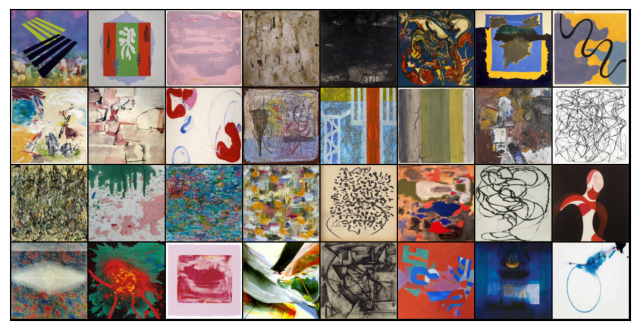

In [8]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break
        
show_image(train_dl)

## Moving to the GPU

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

# Define Discriminator

In [11]:
discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4
    
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [12]:
discriminator = to_device(discriminator, device)

In [13]:
latent_size=128

# Define Generator

In [14]:
generator = nn.Sequential(
    #in: 128 x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()
)

In [15]:
generator = to_device(generator, device)

In [21]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = F.binary_cross_entropy_with_logits(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # KL divergence calculation
    p_real = F.sigmoid(real_preds)
    p_fake = F.sigmoid(fake_preds)
    kl_divergence = torch.mean(p_real * torch.log(p_real / (1 - p_real)) - p_fake * torch.log(p_fake / (1 - p_fake)))
    
    loss = real_loss + fake_loss + kl_divergence  # Add KL divergence to the loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score, kl_divergence.item()

In [22]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    bce_loss = F.binary_cross_entropy(preds, targets)
    
    # Calculate KL divergence between the distribution of generated images and a prior
    prior_mean = torch.zeros_like(fake_images)
    prior_logvar = torch.zeros_like(fake_images)
    kl_div_loss = 0.5 * torch.sum(-prior_logvar + torch.exp(prior_logvar) + (fake_images - prior_mean) ** 2 / torch.exp(prior_logvar) - 1)
    
    # Combine the binary cross-entropy loss and KL divergence loss
    loss = bce_loss + kl_div_loss
    
    loss.backward()
    opt_g.step()
    
    return loss.item(), kl_div_loss.item()


In [18]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [19]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

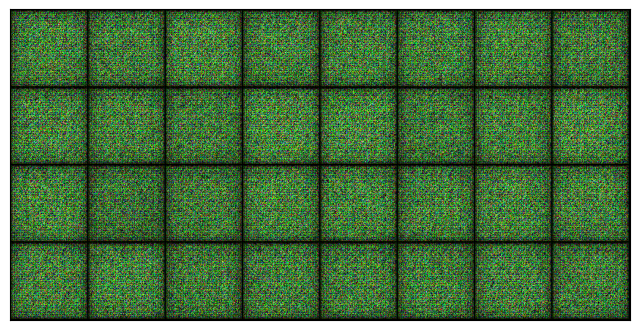

In [20]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [23]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    kl_divs = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d, real_score, fake_score, kl_div = train_discriminator(real_images, opt_d)
            loss_g, _ = train_generator(opt_g)
            
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        kl_divs.append(kl_div)
        
        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, kl_div: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score, kl_div))
        
        save_sample(epoch+start_idx, fixed_latent, show=False)
        
    return losses_d, losses_g, real_scores, fake_scores, kl_divs

In [24]:
epochs = 200
lr_d = 10e-5
lr_g = 10e-4

In [25]:
history = [fit(epochs, lr_d, lr_g, start_idx=1)]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [1/200], loss_d: 1.2769, loss_g: 20430.5156, real_score: 0.0097, fake_score: 0.9928, kl_div: -0.7194


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [2/200], loss_d: 1.2758, loss_g: 13417.1201, real_score: 0.0094, fake_score: 0.9982, kl_div: -0.7246


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [3/200], loss_d: 1.2754, loss_g: 6734.5532, real_score: 0.0044, fake_score: 0.9996, kl_div: -0.7285


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [4/200], loss_d: 1.2754, loss_g: 4717.3062, real_score: 0.0044, fake_score: 0.9999, kl_div: -0.7287


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [5/200], loss_d: 1.2754, loss_g: 3866.9629, real_score: 0.0045, fake_score: 0.9999, kl_div: -0.7287


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [6/200], loss_d: 1.2754, loss_g: 2846.4199, real_score: 0.0024, fake_score: 0.9999, kl_div: -0.7298


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [7/200], loss_d: 1.2754, loss_g: 3758.5525, real_score: 0.0029, fake_score: 1.0000, kl_div: -0.7296


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [8/200], loss_d: 1.2754, loss_g: 4505.5225, real_score: 0.0025, fake_score: 0.9999, kl_div: -0.7297


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [9/200], loss_d: 1.2754, loss_g: 3826.5117, real_score: 0.0018, fake_score: 0.9999, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [10/200], loss_d: 1.2754, loss_g: 2774.7378, real_score: 0.0016, fake_score: 0.9997, kl_div: -0.7300


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [11/200], loss_d: 1.2754, loss_g: 2978.0085, real_score: 0.0018, fake_score: 0.9999, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [12/200], loss_d: 1.2754, loss_g: 1750.0795, real_score: 0.0023, fake_score: 1.0000, kl_div: -0.7299


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [13/200], loss_d: 1.2754, loss_g: 2273.7959, real_score: 0.0019, fake_score: 0.9999, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [14/200], loss_d: 1.2754, loss_g: 1706.7249, real_score: 0.0019, fake_score: 1.0000, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [15/200], loss_d: 1.2754, loss_g: 1974.0278, real_score: 0.0018, fake_score: 1.0000, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [16/200], loss_d: 1.2754, loss_g: 1337.6414, real_score: 0.0013, fake_score: 1.0000, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [17/200], loss_d: 1.2754, loss_g: 1770.4792, real_score: 0.0011, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [18/200], loss_d: 1.2754, loss_g: 1250.7139, real_score: 0.0012, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [19/200], loss_d: 1.2754, loss_g: 1824.8162, real_score: 0.0013, fake_score: 1.0000, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [20/200], loss_d: 1.2754, loss_g: 1907.2698, real_score: 0.0015, fake_score: 0.9999, kl_div: -0.7303


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [21/200], loss_d: 1.2754, loss_g: 1734.8298, real_score: 0.0019, fake_score: 0.9999, kl_div: -0.7300


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [22/200], loss_d: 1.2754, loss_g: 1086.0110, real_score: 0.0012, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [23/200], loss_d: 1.2754, loss_g: 1012.0626, real_score: 0.0008, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [24/200], loss_d: 1.2754, loss_g: 1095.4027, real_score: 0.0020, fake_score: 1.0000, kl_div: -0.7301


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [25/200], loss_d: 1.2754, loss_g: 1299.0676, real_score: 0.0014, fake_score: 1.0000, kl_div: -0.7303


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [26/200], loss_d: 1.2754, loss_g: 1331.7083, real_score: 0.0011, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [27/200], loss_d: 1.2754, loss_g: 957.5452, real_score: 0.0012, fake_score: 1.0000, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [28/200], loss_d: 1.2754, loss_g: 1192.1622, real_score: 0.0008, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [29/200], loss_d: 1.2754, loss_g: 993.0776, real_score: 0.0015, fake_score: 1.0000, kl_div: -0.7303


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [30/200], loss_d: 1.2754, loss_g: 827.5135, real_score: 0.0016, fake_score: 1.0000, kl_div: -0.7302


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [31/200], loss_d: 1.2754, loss_g: 1424.7648, real_score: 0.0011, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [32/200], loss_d: 1.2754, loss_g: 903.3107, real_score: 0.0013, fake_score: 1.0000, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [33/200], loss_d: 1.2754, loss_g: 1317.8027, real_score: 0.0009, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [34/200], loss_d: 1.2754, loss_g: 832.4163, real_score: 0.0010, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [35/200], loss_d: 1.2754, loss_g: 819.3228, real_score: 0.0008, fake_score: 0.9997, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [36/200], loss_d: 1.2754, loss_g: 1296.7339, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [37/200], loss_d: 1.2754, loss_g: 904.4636, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [38/200], loss_d: 1.2754, loss_g: 914.2651, real_score: 0.0005, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [39/200], loss_d: 1.2754, loss_g: 811.7798, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [40/200], loss_d: 1.2754, loss_g: 1235.5195, real_score: 0.0009, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [41/200], loss_d: 1.2754, loss_g: 667.8340, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [42/200], loss_d: 1.2754, loss_g: 823.9053, real_score: 0.0017, fake_score: 1.0000, kl_div: -0.7302


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [43/200], loss_d: 1.2754, loss_g: 613.1901, real_score: 0.0011, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [44/200], loss_d: 1.2754, loss_g: 560.6558, real_score: 0.0008, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [45/200], loss_d: 1.2754, loss_g: 968.0376, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [46/200], loss_d: 1.2754, loss_g: 573.2822, real_score: 0.0008, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [47/200], loss_d: 1.2754, loss_g: 574.2463, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [48/200], loss_d: 1.2754, loss_g: 874.0483, real_score: 0.0010, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [49/200], loss_d: 1.2754, loss_g: 694.3051, real_score: 0.0006, fake_score: 0.9999, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [50/200], loss_d: 1.2754, loss_g: 632.8807, real_score: 0.0012, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [51/200], loss_d: 1.2754, loss_g: 564.8812, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [52/200], loss_d: 1.2754, loss_g: 563.5669, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [53/200], loss_d: 1.2754, loss_g: 633.1429, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [54/200], loss_d: 1.2754, loss_g: 522.8571, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [55/200], loss_d: 1.2754, loss_g: 381.9515, real_score: 0.0011, fake_score: 1.0000, kl_div: -0.7305


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [56/200], loss_d: 1.2754, loss_g: 580.9075, real_score: 0.0005, fake_score: 0.9999, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [57/200], loss_d: 1.2754, loss_g: 467.2620, real_score: 0.0010, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [58/200], loss_d: 1.2754, loss_g: 509.8199, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [59/200], loss_d: 1.2754, loss_g: 608.4092, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [60/200], loss_d: 1.2754, loss_g: 318.1496, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [61/200], loss_d: 1.2754, loss_g: 616.8951, real_score: 0.0009, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [62/200], loss_d: 1.2754, loss_g: 376.0250, real_score: 0.0008, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [63/200], loss_d: 1.2754, loss_g: 634.0653, real_score: 0.0009, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [64/200], loss_d: 1.2754, loss_g: 443.1333, real_score: 0.0013, fake_score: 1.0000, kl_div: -0.7304


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [65/200], loss_d: 1.2754, loss_g: 453.3320, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [66/200], loss_d: 1.2754, loss_g: 544.3272, real_score: 0.0005, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [67/200], loss_d: 1.2754, loss_g: 378.7234, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [68/200], loss_d: 1.2754, loss_g: 432.0963, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [69/200], loss_d: 1.2754, loss_g: 471.0041, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [70/200], loss_d: 1.2754, loss_g: 526.1974, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [71/200], loss_d: 1.2754, loss_g: 502.1073, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [72/200], loss_d: 1.2754, loss_g: 677.8176, real_score: 0.0010, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [73/200], loss_d: 1.2754, loss_g: 502.9885, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [77/200], loss_d: 1.2754, loss_g: 303.4007, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [78/200], loss_d: 1.2754, loss_g: 369.9814, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [79/200], loss_d: 1.2754, loss_g: 364.4727, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [80/200], loss_d: 1.2754, loss_g: 274.2153, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [81/200], loss_d: 1.2754, loss_g: 423.0196, real_score: 0.0009, fake_score: 1.0000, kl_div: -0.7306


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [82/200], loss_d: 1.2754, loss_g: 333.8427, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [83/200], loss_d: 1.2754, loss_g: 387.9950, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [84/200], loss_d: 1.2754, loss_g: 483.7908, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [85/200], loss_d: 1.2754, loss_g: 331.0690, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [86/200], loss_d: 1.2754, loss_g: 340.7547, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [87/200], loss_d: 1.2754, loss_g: 484.4137, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [88/200], loss_d: 1.2754, loss_g: 281.5016, real_score: 0.0005, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [89/200], loss_d: 1.2754, loss_g: 249.8591, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [90/200], loss_d: 1.2754, loss_g: 244.9093, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [91/200], loss_d: 1.2754, loss_g: 587.8152, real_score: 0.0007, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [92/200], loss_d: 1.2754, loss_g: 269.8075, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309
Epoch: [95/200], loss_d: 1.2754, loss_g: 326.1394, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [96/200], loss_d: 1.2754, loss_g: 338.7097, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [97/200], loss_d: 1.2754, loss_g: 277.7995, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [98/200], loss_d: 1.2754, loss_g: 301.2820, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [99/200], loss_d: 1.2754, loss_g: 318.6784, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [100/200], loss_d: 1.2754, loss_g: 326.0346, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [101/200], loss_d: 1.2754, loss_g: 224.9570, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [102/200], loss_d: 1.2754, loss_g: 267.8896, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [103/200], loss_d: 1.2754, loss_g: 304.9462, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [104/200], loss_d: 1.2754, loss_g: 213.5065, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [105/200], loss_d: 1.2754, loss_g: 273.5348, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [106/200], loss_d: 1.2754, loss_g: 258.5451, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [107/200], loss_d: 1.2754, loss_g: 412.6833, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [108/200], loss_d: 1.2754, loss_g: 264.2962, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [109/200], loss_d: 1.2754, loss_g: 328.9943, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [110/200], loss_d: 1.2754, loss_g: 272.6165, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7307


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [111/200], loss_d: 1.2754, loss_g: 315.6727, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [112/200], loss_d: 1.2754, loss_g: 257.2367, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [113/200], loss_d: 1.2754, loss_g: 277.3936, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [114/200], loss_d: 1.2754, loss_g: 216.8577, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [115/200], loss_d: 1.2754, loss_g: 232.0446, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [116/200], loss_d: 1.2754, loss_g: 270.6165, real_score: 0.0005, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [117/200], loss_d: 1.2754, loss_g: 213.8490, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [118/200], loss_d: 1.2754, loss_g: 253.6439, real_score: 0.0006, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [119/200], loss_d: 1.2754, loss_g: 234.8159, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [120/200], loss_d: 1.2754, loss_g: 292.3852, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [121/200], loss_d: 1.2754, loss_g: 319.3538, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [122/200], loss_d: 1.2754, loss_g: 226.0537, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [123/200], loss_d: 1.2754, loss_g: 225.7336, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [124/200], loss_d: 1.2754, loss_g: 173.2785, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [125/200], loss_d: 1.2754, loss_g: 193.5990, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [126/200], loss_d: 1.2754, loss_g: 195.0409, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [127/200], loss_d: 1.2754, loss_g: 194.2711, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [128/200], loss_d: 1.2754, loss_g: 295.9348, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [129/200], loss_d: 1.2754, loss_g: 195.0577, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [130/200], loss_d: 1.2754, loss_g: 267.3746, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [131/200], loss_d: 1.2754, loss_g: 192.7291, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [132/200], loss_d: 1.2754, loss_g: 190.0088, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [133/200], loss_d: 1.2754, loss_g: 219.2474, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [134/200], loss_d: 1.2754, loss_g: 174.6581, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [135/200], loss_d: 1.2754, loss_g: 161.5491, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [136/200], loss_d: 1.2754, loss_g: 235.7947, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [137/200], loss_d: 1.2754, loss_g: 175.2584, real_score: 0.0005, fake_score: 1.0000, kl_div: -0.7308


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [138/200], loss_d: 1.2754, loss_g: 133.4176, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [139/200], loss_d: 1.2754, loss_g: 188.0773, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [140/200], loss_d: 1.2754, loss_g: 275.2453, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [141/200], loss_d: 1.2754, loss_g: 224.6134, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [142/200], loss_d: 1.2754, loss_g: 174.3861, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [143/200], loss_d: 1.2754, loss_g: 232.6910, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [144/200], loss_d: 1.2754, loss_g: 179.7183, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [145/200], loss_d: 1.2754, loss_g: 202.4172, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [146/200], loss_d: 1.2754, loss_g: 186.3901, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [147/200], loss_d: 1.2754, loss_g: 294.1217, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [148/200], loss_d: 1.2754, loss_g: 225.8258, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [149/200], loss_d: 1.2754, loss_g: 154.6769, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [150/200], loss_d: 1.2754, loss_g: 134.5807, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [151/200], loss_d: 1.2754, loss_g: 134.3207, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [152/200], loss_d: 1.2754, loss_g: 150.2651, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [153/200], loss_d: 1.2754, loss_g: 186.3496, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [154/200], loss_d: 1.2754, loss_g: 165.1063, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [155/200], loss_d: 1.2754, loss_g: 114.0303, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [156/200], loss_d: 1.2754, loss_g: 150.7888, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [157/200], loss_d: 1.2754, loss_g: 164.9826, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [158/200], loss_d: 1.2754, loss_g: 198.7124, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [159/200], loss_d: 1.2754, loss_g: 141.2479, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [160/200], loss_d: 1.2754, loss_g: 155.5190, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [161/200], loss_d: 1.2754, loss_g: 93.3267, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [162/200], loss_d: 1.2754, loss_g: 152.3898, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [163/200], loss_d: 1.2754, loss_g: 122.0799, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [164/200], loss_d: 1.2754, loss_g: 132.1362, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [165/200], loss_d: 1.2754, loss_g: 103.6078, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [166/200], loss_d: 1.2754, loss_g: 135.7700, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [167/200], loss_d: 1.2754, loss_g: 162.9190, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [168/200], loss_d: 1.2754, loss_g: 200.8600, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [169/200], loss_d: 1.2754, loss_g: 121.2893, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [170/200], loss_d: 1.2754, loss_g: 139.3459, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [171/200], loss_d: 1.2754, loss_g: 131.2985, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [172/200], loss_d: 1.2754, loss_g: 107.4398, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [173/200], loss_d: 1.2754, loss_g: 126.7298, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [174/200], loss_d: 1.2754, loss_g: 150.5874, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [175/200], loss_d: 1.2754, loss_g: 134.7161, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [176/200], loss_d: 1.2754, loss_g: 113.8882, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [177/200], loss_d: 1.2754, loss_g: 90.5596, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [178/200], loss_d: 1.2754, loss_g: 101.2696, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [179/200], loss_d: 1.2754, loss_g: 123.9278, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [180/200], loss_d: 1.2754, loss_g: 223.4568, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [181/200], loss_d: 1.2754, loss_g: 109.6597, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [182/200], loss_d: 1.2754, loss_g: 126.7852, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [183/200], loss_d: 1.2754, loss_g: 162.8670, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [184/200], loss_d: 1.2754, loss_g: 166.1537, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [185/200], loss_d: 1.2754, loss_g: 112.5049, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [186/200], loss_d: 1.2754, loss_g: 141.7275, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [187/200], loss_d: 1.2754, loss_g: 72.5820, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [188/200], loss_d: 1.2754, loss_g: 91.6373, real_score: 0.0002, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [189/200], loss_d: 1.2754, loss_g: 107.0249, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [190/200], loss_d: 1.2754, loss_g: 157.6334, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [191/200], loss_d: 1.2754, loss_g: 87.7260, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [192/200], loss_d: 1.2754, loss_g: 98.4998, real_score: 0.0003, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [193/200], loss_d: 1.2754, loss_g: 108.9531, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [194/200], loss_d: 1.2754, loss_g: 82.6145, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [195/200], loss_d: 1.2754, loss_g: 124.9131, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [196/200], loss_d: 1.2754, loss_g: 97.6912, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [197/200], loss_d: 1.2754, loss_g: 115.7073, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [198/200], loss_d: 1.2754, loss_g: 104.6779, real_score: 0.0004, fake_score: 1.0000, kl_div: -0.7309


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [199/200], loss_d: 1.2754, loss_g: 79.5163, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [200/200], loss_d: 1.2754, loss_g: 86.8483, real_score: 0.0001, fake_score: 1.0000, kl_div: -0.7310


In [ ]:
def plot_losses(losses_d, losses_g, kl_divs):
    epochs = range(1, len(losses_d) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses_d, label='Discriminator Loss')
    plt.plot(epochs, losses_g, label='Generator Loss')
    plt.plot(epochs, kl_divs, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_losses(losses_d, losses_g, kl_divs)

# Generate the new Data

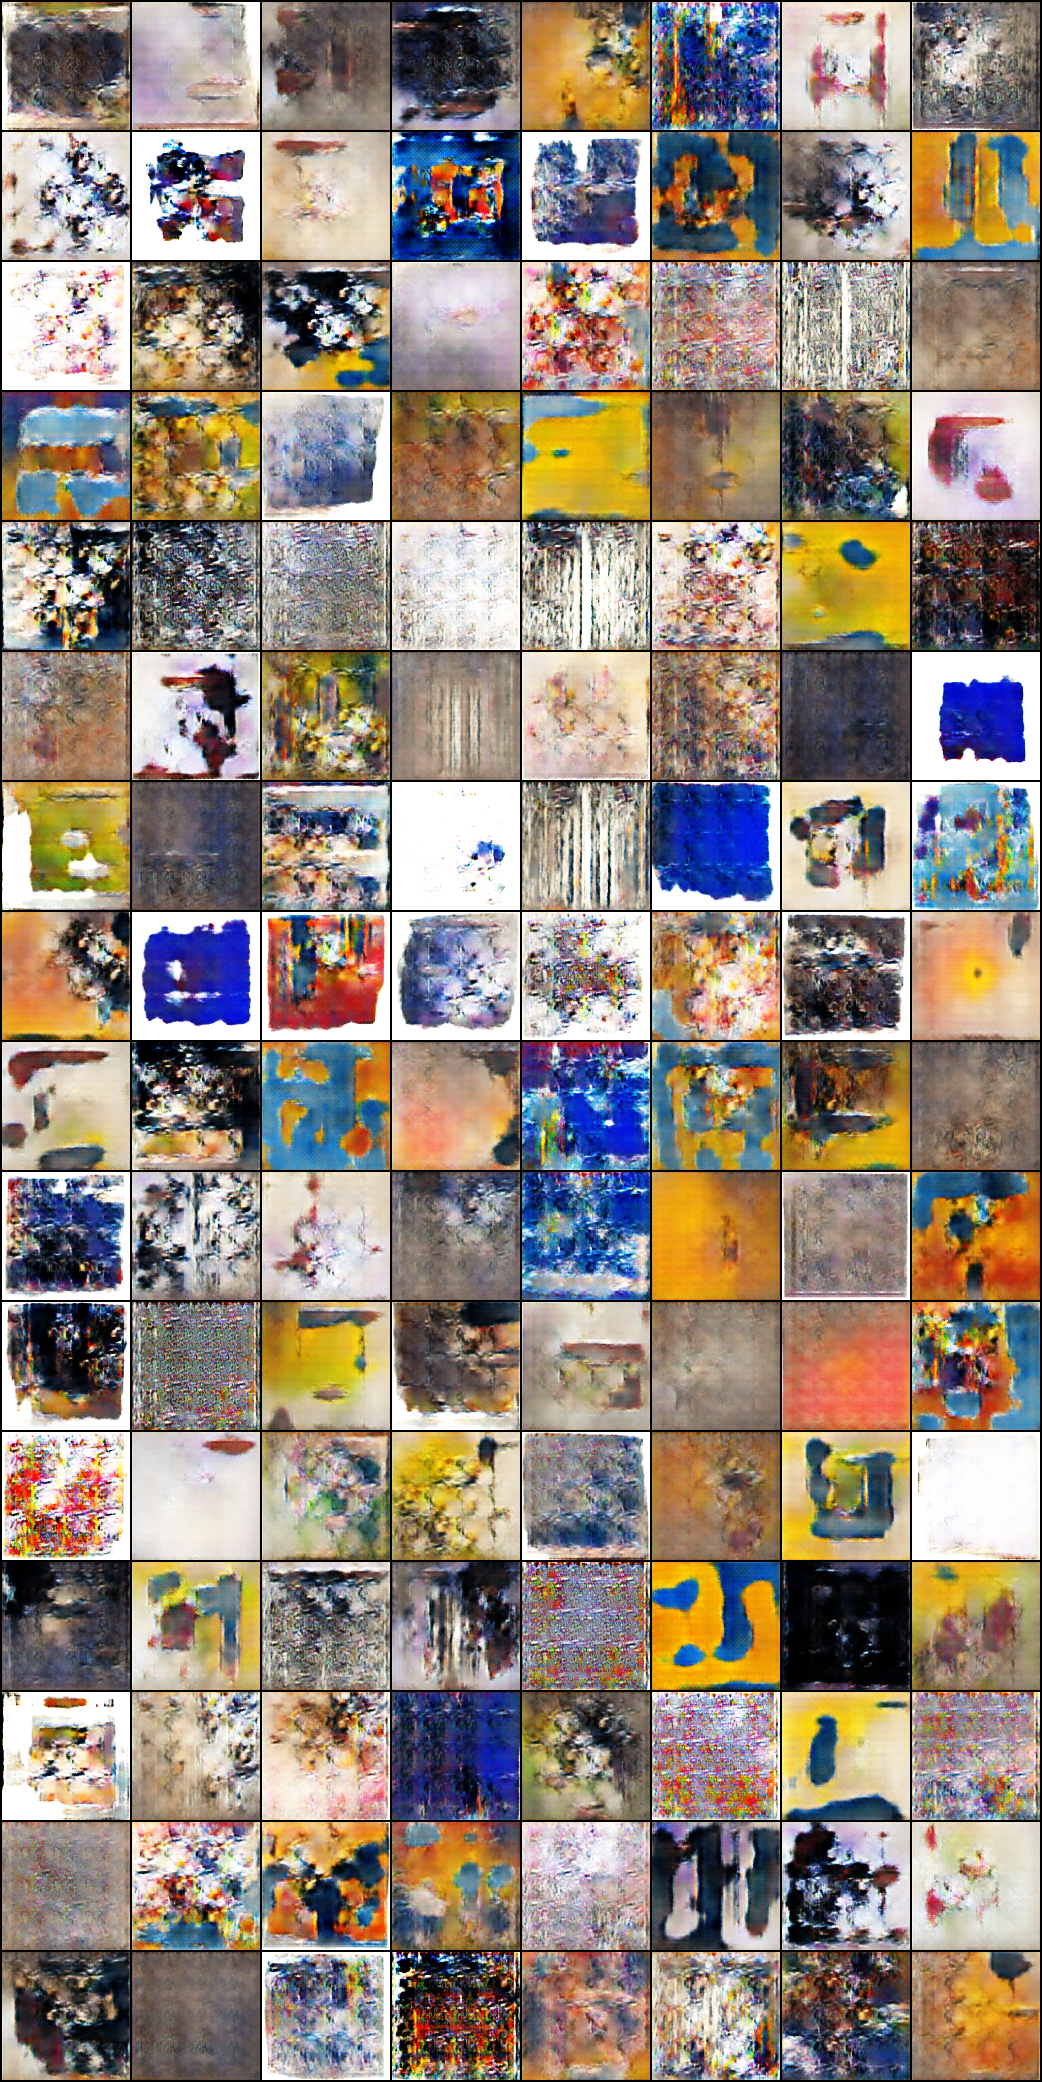

In [24]:
Image("./generated/generated-images-0200.png")